   work_year experience_level employment_type               job_title  salary  \
0       2022               EN              FT   Cyber Program Manager   63000   
1       2022               MI              FT        Security Analyst   95000   
2       2022               MI              FT        Security Analyst   70000   
3       2022               MI              FT     IT Security Analyst  250000   
4       2022               EN              CT  Cyber Security Analyst  120000   

  salary_currency  salary_in_usd employee_residence  remote_ratio  \
0             USD          63000                 US            50   
1             USD          95000                 US             0   
2             USD          70000                 US             0   
3             BRL          48853                 BR            50   
4             USD         120000                 BW           100   

  company_location company_size  
0               US            S  
1               US            

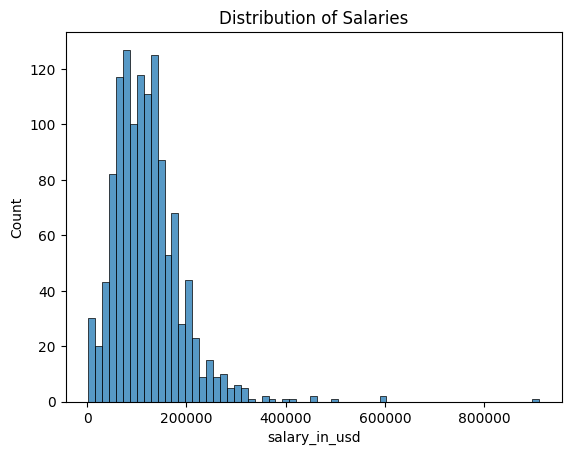

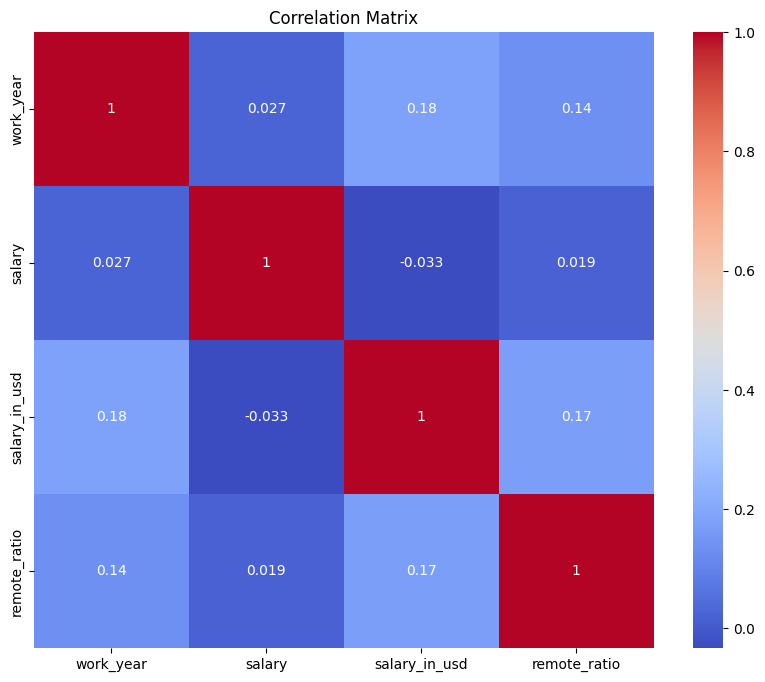

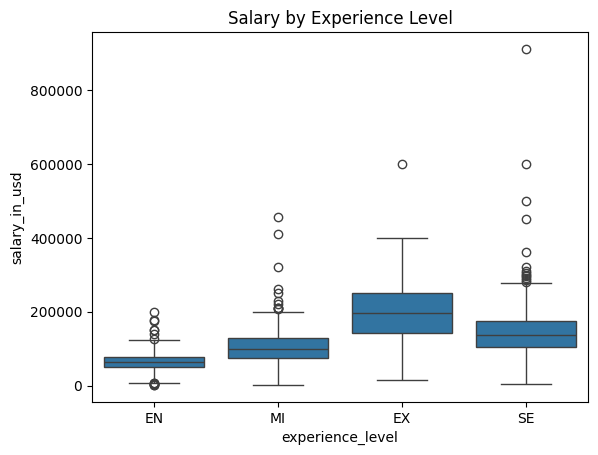

Linear Regression Performance:
Mean Absolute Error: 35205.09186668796
Mean Squared Error: 2785827447.96779
Root Mean Squared Error: 52780.93830132039
R^2 Score: 0.4130877661212988


Decision Tree Performance:
Mean Absolute Error: 39635.58411363637
Mean Squared Error: 3706483996.933998
Root Mean Squared Error: 60880.900099571445
R^2 Score: 0.21912579184935155


Random Forest Performance:
Mean Absolute Error: 36134.05227973851
Mean Squared Error: 2963269657.934004
Root Mean Squared Error: 54435.9224954809
R^2 Score: 0.37570461666901867




In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

# Step 1: Understanding the Dataset
data = pd.read_csv("C:\\Users\\lenovo\\Desktop\\salaries_cyber.csv")
print(data.head())
print(data.info())

# Step 2: Exploratory Data Analysis (EDA)
sns.histplot(data['salary_in_usd'])
plt.title('Distribution of Salaries')
plt.show()

# Select only numeric columns for the correlation matrix
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(10, 8))
sns.heatmap(data[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

sns.boxplot(x='experience_level', y='salary_in_usd', data=data)
plt.title('Salary by Experience Level')
plt.show()

# Step 3: Data Preprocessing
# Handling missing values
data.dropna(inplace=True)

# Feature Engineering
experience_level_mapping = {'EN': 1, 'MI': 2, 'SE': 3, 'EX': 4}
data['experience_level_num'] = data['experience_level'].map(experience_level_mapping)
data['work_experience_interaction'] = data['work_year'] * data['experience_level_num']

employment_type_mapping = {'PT': 1, 'FT': 2, 'CT': 3, 'FL': 4}
data['employment_type_num'] = data['employment_type'].map(employment_type_mapping)
data['remote_employment_interaction'] = data['remote_ratio'] * data['employment_type_num']

company_size_mapping = {'S': 1, 'M': 2, 'L': 3}
data['company_size_num'] = data['company_size'].map(company_size_mapping)
data['employee_residence_num'] = data['employee_residence'].factorize()[0]
data['company_employee_residence_interaction'] = data['company_size_num'] * data['employee_residence_num']

# Identify categorical and numerical columns
categorical_cols = ['experience_level', 'employment_type', 'job_title', 'employee_residence', 'company_location', 'company_size']
numerical_cols = ['work_year', 'remote_ratio', 'work_experience_interaction', 
                  'remote_employment_interaction', 'company_employee_residence_interaction']

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Preprocess the data
X = data.drop(columns=['salary', 'salary_currency', 'experience_level_num', 
                       'employment_type_num', 'company_size_num', 'employee_residence_num', 'salary_in_usd'])
y = data['salary_in_usd']  

# Step 5: Splitting the Dataset
# Divide the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and transform the training data, and transform the test data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Step 6: Model Selection and Training the Models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(random_state=42)
}

model_performance = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, y_pred)
    
    model_performance[model_name] = {
        'Mean Absolute Error': mae,
        'Mean Squared Error': mse,
        'Root Mean Squared Error': rmse,
        'R^2 Score': r2
    }

for model_name, metrics in model_performance.items():
    print(f"{model_name} Performance:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value}")
    print("\n")

# Step 9: Fine-Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2')
grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)

mae_best_rf = mean_absolute_error(y_test, y_pred_best_rf)
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
rmse_best_rf = mse_best_rf ** 0.5
r2_best_rf = r2_score(y_test, y_pred_best_rf)

print("Best Random Forest Performance:")
print("Mean Absolute Error:", mae_best_rf)
print("Mean Squared Error:", mse_best_rf)
print("Root Mean Squared Error:", rmse_best_rf)
print("R^2 Score:", r2_best_rf)

# Interpretation of Results
importances = best_rf_model.feature_importances_
feature_names = preprocessor.transformers_[0][2].tolist() + preprocessor.transformers_[1][1].get_feature_names_out(categorical_cols).tolist()
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
print(feature_importance_df)
